In [1]:
import pandas as pd
import numpy as np

# data vis stuff
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# date and time handling
from datetime import datetime, date
from dateutil.relativedelta import relativedelta

In [2]:
sns.set(style="whitegrid", palette="ch:r=-.2,d=.3_r")

In [3]:
# bring in data sources
nd = pd.read_csv('non_deleted 20180901.csv')
de = pd.read_csv('deleted 20180901.csv')
t_stat = pd.read_csv('theme status.csv')
p_stat = pd.read_csv('plugin status.csv')
ga = pd.read_csv('GA All 20170826-20180826.csv', thousands=',')
ga_admin = pd.read_csv('GA Admin 20170826-20180826.csv', thousands=',')
plugins = pd.read_csv('plugins 20180827.csv')
st = pd.read_csv('updateSiteType 20180917.csv')

In [4]:
# add column to reflect deleted status
nd['deleted'] = False
de['deleted'] = True

In [5]:
# build main table with all sites
# each site is row
sites = pd.concat([nd, de])
sites = sites.reset_index(drop=True)

In [6]:
sites['dur'] = pd.to_datetime(sites['last_updated']) - pd.to_datetime(sites['registered'])
sites['dur'].describe()
# sites['dur'].astype('timedelta64[s]')

count                       10186
mean     181 days 14:28:16.182505
std      272 days 10:13:35.347831
min               0 days 04:00:00
25%               0 days 05:00:01
50%              34 days 23:07:41
75%             317 days 21:29:12
max            2078 days 19:46:04
Name: dur, dtype: object

In [7]:
# breaking out year and month could be useful in predictive ML, but not necessary here
# sites['r_year'] = pd.to_datetime(sites['registered']).apply(lambda x: x.year)
# sites['r_month'] = pd.to_datetime(sites['registered']).apply(lambda x: x.month)

In [8]:
# find academic year
sites['r_ay'] = pd.to_datetime(sites['registered']).apply(lambda x: \
                                                            x.year+1 if x.month > 8 \
                                                            else x.year)

In [9]:
# theme accessibility status
sites = pd.merge(sites, t_stat, on='current_theme')

# rename column for clarity
sites.rename(columns={'accessible': 'accessible theme'}, inplace=True)

In [10]:
# bring in plugins with activation and accessibility counts
'''
plugin_list is derived from:
int64_columns = plugins.select_dtypes([np.number]).columns
int64_columns
'''
plugin_list = ['aesop-story-engine', 'akismet', 'attachment-importer',
       'autoblog', 'bbpress', 'bwp-minify', 'comment-image',
       'contus-video-gallery', 'custom-sidebars', 'display-posts-shortcode',
       'duplicate-post', 'editorial-access-manager', 'email-users',
       'embed-webmap', 'enable-media-replace', 'every-calendar-1',
       'feedwordpress', 'footnotes', 'google-document-embedder', 'gutenberg',
       'iframe', 'image-wall', 'import-users-from-csv', 'jetpack',
       'leaflet-maps-marker', 'legacy-jetpack-custom-css-editor', 'lock-posts',
       'login-logout-register-menu', 'nextgen-gallery',
       'photo-video-gallery-master', 'pinterest-rss-widget',
       'post-type-switcher', 'shibboleth-fix', 'simple-mathjax',
       'subscribe-by-email', 'syntaxhighlighter', 'the-events-calendar',
       'tt-guest-post-submit', 'tumblr-widget-for-wordpress',
       'user-submitted-posts', 'wp-accessibility', 'wp-gallery-custom-links',
       'wp-pro-quiz', 'wp-recaptcha', 'wp-views', 'wpmu-dev-post-votes',
       'wpmu_dev_maps_plugin', 'yop-poll', 'zotpress']

# iterate through columns and convert data type to bool
for col in plugin_list:
    plugins[col] = plugins[col].astype(bool)
    
# create list of inaccessible, user-activated plugins
f_inac_p = p_stat['Plugin'].loc[(p_stat['Frontend Accessible'] == 'No') & \
                                (p_stat['Network Active'] == 'No')].tolist()

# create list of all inaccessible plugins
inac_p = p_stat['Plugin'].loc[p_stat['Accessible'] == 'No'].tolist()

# count active plugins on site
plugins['total active'] = plugins[plugin_list].sum(axis=1)

# count inaccessible, user activated plugins per site
plugins['front inacc plugins'] = plugins[f_inac_p].sum(axis=1)
plugins['inacc plugins'] = plugins[inac_p].sum(axis=1)

# prep plugins df to merge into main sites df
plugins.drop(['domain', 'path', 'registered', 'last_updated', 'admin_email', 'theme'], axis=1, inplace=True)

# join to sites df
sites = pd.merge(sites, plugins, on='blog_id')

In [11]:
# prep GA and GA admin for join
ga.drop(['Bounce Rate', '% Exit'], axis=1, inplace=True)
ga_admin.drop(['Page path level 2', 'Bounce Rate', '% Exit'], axis=1, inplace=True)

# join to sites
sites = pd.merge(sites, ga, left_on='blog_url', right_on='Page path level 1', how='left')
sites = pd.merge(sites, ga_admin, left_on='blog_url', right_on='Page path level 1', how='left', suffixes=('','_admin'))

# clean leftover ga columns
sites.drop(['Page path level 1', 'Page path level 1_admin'], axis=1, inplace=True)

# set NaNs to 0 - no traffic on site
sites[['Pageviews', 'Unique Pageviews', 'Avg. Time on Page', 'Pageviews_admin',
       'Unique Pageviews_admin', 'Avg. Time on Page_admin']] = sites[['Pageviews', 'Unique Pageviews', 'Avg. Time on Page', 'Pageviews_admin',
       'Unique Pageviews_admin', 'Avg. Time on Page_admin']].fillna(0)

In [12]:
# drop original site_type column
sites.drop('site_type', axis=1,inplace=True)

In [13]:
# drop url
st.drop('url', axis=1, inplace=True)

In [14]:
sites = pd.merge(sites, st, on='blog_id')

In [15]:
# convert registered and lastmod to datetime for analysis
sites['registered'] = pd.to_datetime(sites['registered'])
sites['last_updated'] = pd.to_datetime(sites['last_updated'])

In [16]:
'''
create function to define active sites
r = creation (registered) timestamp
l = last_updated timestamp
ap = admin pageviews
tp = total pageviews

r_date = will check if site was created more than 1yr before this date
l_date = will check if site was modified more than 1yr before this date
tp_min = minimum number of total pageviews to be considered active
ap_min = minimum number of admin pageviews to be considered active
''' 

r_date = date(2018,8,27) 
l_date = date(2018,8,27)
tp_min = 2
ap_min = 1 # not currently in use

def check_active(r, l, ap, tp):
    if r < pd.Timestamp(r_date) - relativedelta(years=1) and \
    l < pd.Timestamp(l_date) - relativedelta(years=1) and \
    tp < tp_min:
        return False 
    else:
        return True

# returns number of active sites with the above criteria
sum(sites.apply(lambda row: check_active(row['registered'], row['last_updated'], row['Pageviews_admin'], row['Pageviews']),axis=1))

5348

In [17]:
# apply check_active to all sites and mark with bool
sites['active'] = sites.apply(lambda row: check_active(row['registered'], row['last_updated'], row['Pageviews_admin'], row['Pageviews']),axis=1)

In [18]:
# save out to csv
sites.to_csv('sites.csv', index=False)

In [19]:
# GROWTH - SITES
# total sites
sites['blog_id'].nunique()

9963

In [20]:
# active sites
sites['blog_id'].loc[sites['active'] == True].count()

5348

In [21]:
# active themes
sites['current_theme'].loc[(sites['deleted'] == False) &\
                          (sites['active'] == True) &\
                          (sites['archived'] == False)].nunique()

62

In [22]:
# accessible themes
t_stat['accessible'].sum()

27

In [23]:
# accessible plugins
p_stat.loc[(p_stat['Frontend Accessible'] == 'Yes') &\
                 (p_stat['Accessible'] == 'Yes')].count()

Plugin                 43
Frontend Accessible    43
Accessible             43
Network Active         43
dtype: int64

In [24]:
# get site registered dates into a more usable format
sc = sites[['registered', 'active', 'site type', 'r_ay']]

In [25]:
sc['Week'] = sc['registered'].apply(lambda x: x.week)
sc['Month'] = sc['registered'].apply(lambda x: x.month)
sc['Year'] = sc['registered'].apply(lambda x: x.year)


/Users/peterarbaugh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/peterarbaugh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/peterarbaugh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [26]:
pd.pivot_table(sc, index=['Year', 'site type'], values=['registered'], aggfunc=pd.Series.nunique)

registered
Year site type                      
2012 Teaching & Learning           1
2014 Administrative               39
     Portfolio                    51
     Research                     18
     Site Deleted                520
     Teaching & Learning          80
2015 Administrative               82
     Portfolio                   224
     Research                     22
     Site Deleted                659
     Teaching & Learning         920
2016 Administrative              149
     Portfolio                  1152
     Research                    111
     Site Deleted                 94
     Teaching & Learning         874
2017 Administrative              213
     Portfolio                  1523
     Research                    278
     Site Deleted                161
     Teaching & Learning         942
2018 Administrative              182
     Portfolio                   581
     Research                     76
     Site Deleted                168
     Teaching & Learning         690

In [27]:
sc[sc['site type'] == 'Portfolio'].groupby(['Year','Month']).count()

registered  active  site type  r_ay  Week
Year Month                                           
2014 7               4       4          4     4     4
     8              12      12         12    12    12
     9              12      12         12    12    12
     10             12      12         12    12    12
     11              7       7          7     7     7
     12              4       4          4     4     4
2015 1               5       5          5     5     5
     2               2       2          2     2     2
     3               9       9          9     9     9
     4              10      10         10    10    10
     5              12      12         12    12    12
     6               6       6          6     6     6
     7               6       6          6     6     6
     8               6       6          6     6     6
     9              15      15         15    15    15
     10              9       9          9     9     9
     11             82      82         82    82    82
     12             64      64         64    64    64
2016 1              96      96         96    96    96
     2              85      85         85    85    85
     3              63      63         63    63    63
     4              61      61         61    61    61
     5              34      34         34    34    34
     6              44      44         44    44    44
     7             148     148        148   148   148
     8             375     375        375   375   375
     9              90      90         90    90    90
     10             43      43         43    43    43
     11             60      60         60    60    60
     12             55      55         55    55    55
2017 1             101     101        101   101   101
     2             107     107        107   107   107
     3             106     106        106   106   106
     4              52      52         52    52    52
     5              64      64         64    64    64
     6              57      57         57    57    57
     7             428     428        428   428   428
     8              54      54         54    54    54
     9             337     337        337   337   337
     10             60      60         60    60    60
     11             78      78         78    78    78
     12             84      84         84    84    84
2018 1             171     171        171   171   171
     2             129     129        129   129   129
     3              82      82         82    82    82
     4              40      40         40    40    40
     5              67      67         67    67    67
     6              41      41         41    41    41
     7              39      39         39    39    39
     8              17      17         17    17    17

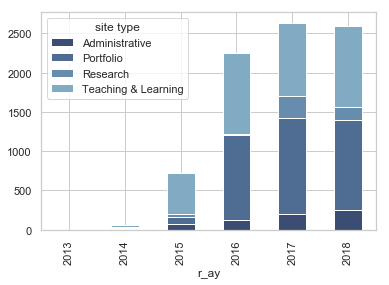

In [28]:
sc[sc['site type'] != 'Site Deleted'].groupby('r_ay')['site type'].value_counts().unstack(level=1).plot(kind='bar', stacked=True)

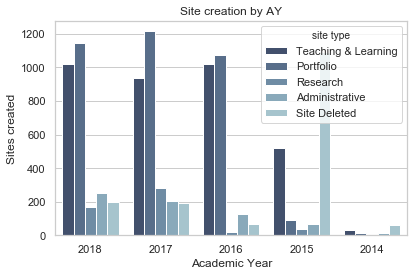

In [29]:
# raw site creation count
g = sns.countplot(x='r_ay', hue='site type', data=sites, order=[2018,2017,2016,2015,2014],)
plt.title("Site creation by AY")
plt.xlabel("Academic Year")
plt.ylabel("Sites created")
plt.tight_layout()
plt.savefig("site creation AY.png", format="png", dpi=1200)

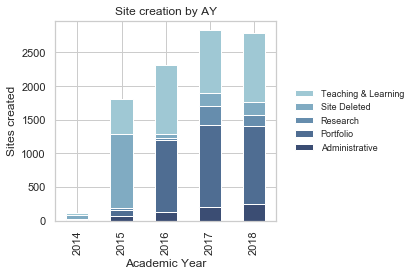

In [30]:
sc[sc['r_ay'] != 2013].groupby('r_ay')['site type'].value_counts().unstack(level=1).plot(kind='bar', stacked=True)
plt.title("Site creation by AY")
plt.xlabel("Academic Year")
plt.ylabel("Sites created")
plt.legend(title=False, loc=6, bbox_to_anchor=(1.05, 0.5), labelspacing=-2.5, frameon=False,fontsize=9.0)
plt.tight_layout()
plt.savefig("site creation AY stacked.png", format="png", dpi=300)

In [31]:
sc.to_csv('site_trend_data.csv', index=False)

In [32]:
# CURRENT state
# unique pageviews
sites['Unique Pageviews'].sum()

3812473.0

In [33]:
# unique pageviews in the admin
sites['Unique Pageviews_admin'].sum()

407071.0

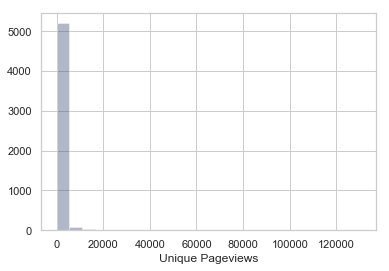

In [34]:
# distribution of unique pageviews for active sites - would be easier to explore in plotly
sns.distplot(sites['Unique Pageviews'].loc[sites['active'] == True], kde=False, bins=24)

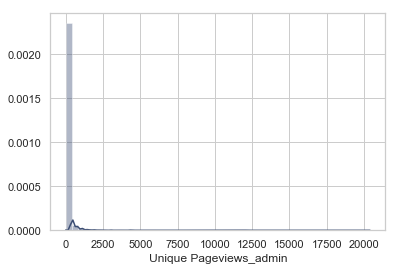

In [35]:
# dist of admin pageviews 
sns.distplot(sites['Unique Pageviews_admin'].loc[sites['active'] == True])

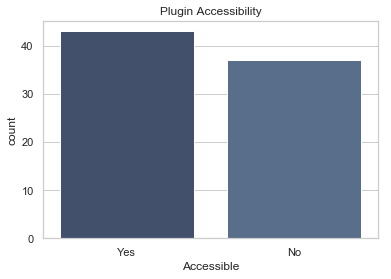

In [36]:
# accessible plugins in system
# The majority of our inaccessible plugins are accessible on the front end of the site.

g = sns.countplot(x="Accessible", data=p_stat, order=["Yes", "No"])
plt.title("Plugin Accessibility")
plt.savefig("plugin accessibility.png", format="png", dpi=600)

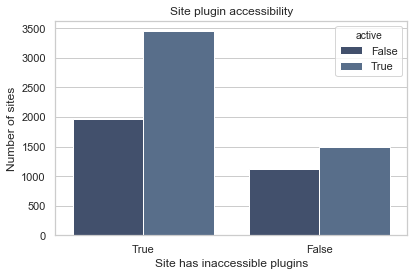

In [37]:
# count of sites with inaccessible plugins and by active
sip = sites[['inacc plugins', 'active']].loc[(sites['deleted'] == False) &\
         (sites['archived'] == False)]
sip['inacc plugins bool'] = sites['inacc plugins'] > 0

g = sns.countplot(x='inacc plugins bool', data=sip, hue='active', order=[True,False])
plt.ylabel('Number of sites')
plt.xlabel('Site has inaccessible plugins')
plt.title('Site plugin accessibility')
plt.tight_layout()
plt.savefig("count accessible plugins.png", format="png", dpi=600)

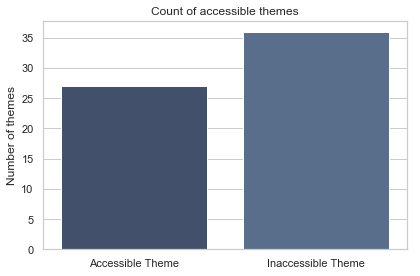

In [38]:
ta = sites['current_theme'].loc[(sites['deleted'] == False) &\
         (sites['archived'] == False)].value_counts().to_frame()
ta = pd.merge(ta,t_stat, right_on='current_theme', left_index=True)
ta.drop('current_theme_y', axis=1,inplace=True)
ta.rename(index=str, columns={"current_theme_x":"activations"}, inplace=True)

g = sns.countplot(x='accessible', data=ta, order=[True,False])
g.set(xticklabels=["Accessible Theme", "Inaccessible Theme"])
plt.ylabel('Number of themes')
plt.xlabel('')
plt.title('Count of accessible themes')
plt.tight_layout()
plt.savefig("count accessible themes.png", format="png", dpi=600)

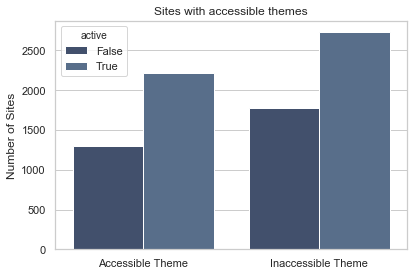

In [39]:
sat = sites.loc[(sites['deleted'] == False) &\
         (sites['archived'] == False)]
g = sns.countplot(x='accessible theme', data=sat, order=[True,False], hue='active')
g.set(xticklabels=["Accessible Theme", "Inaccessible Theme"])
plt.ylabel('Number of Sites')
plt.xlabel('')
plt.title('Sites with accessible themes')
plt.tight_layout()
plt.savefig("theme accessibility active.png", format="png", dpi=600)

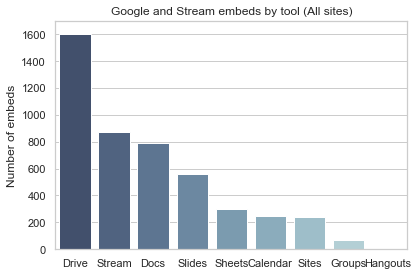

In [40]:
# OTHER TOOLs
# Google tool embeds over all sites
g_embeds = sites[['Google Drive embeds (count)',
 'Google Docs embeds (count)',
 'Google Sheets embeds (count)',
 'Google Slides embeds (count)',
 'Google Calendar embeds (count)',
 'Google Groups embeds (count)',
 'Google Hangouts embeds (count)',
 'Google Sites embeds (count)',
 'NYU Stream embeds (count)']]

g_embeds.columns = ['Drive','Docs', 'Sheets', 'Slides', 'Calendar', 'Groups', 'Hangouts', 'Sites', 'Stream']
g_embeds = g_embeds.sum().sort_values(ascending=False).to_frame()
g_embeds = g_embeds.reset_index()
g_embeds = g_embeds.rename(columns={0: "a", 1: "c"})

# plot
g = sns.barplot(x="index",y="a", data=g_embeds, palette="ch:r=-.2,d=.3_r")
plt.title('Google and Stream embeds by tool (All sites)')
plt.ylabel('Number of embeds')
plt.xlabel('')
plt.ylim((0,1700))
plt.tight_layout()
plt.savefig("WP Embeds by tool.png", format="png", dpi=600)

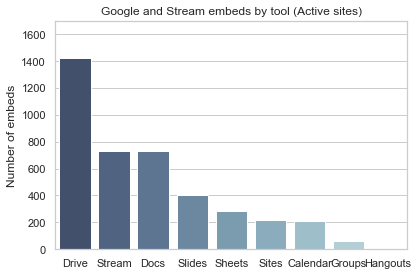

In [41]:
# Google tool embeds over active sites
g_embeds_a = sites[['Google Drive embeds (count)',
 'Google Docs embeds (count)',
 'Google Sheets embeds (count)',
 'Google Slides embeds (count)',
 'Google Calendar embeds (count)',
 'Google Groups embeds (count)',
 'Google Hangouts embeds (count)',
 'Google Sites embeds (count)',
 'NYU Stream embeds (count)']].loc[sites['active'] == True]

g_embeds_a.columns = ['Drive','Docs', 'Sheets', 'Slides', 'Calendar', 'Groups', 'Hangouts', 'Sites', 'Stream']
g_embeds_a = g_embeds_a.sum().sort_values(ascending=False).to_frame()
g_embeds_a = g_embeds_a.reset_index()
g_embeds_a = g_embeds_a.rename(columns={0: "a", 1: "c"})

# plot
g = sns.barplot(x="index",y="a", data=g_embeds_a, palette="ch:r=-.2,d=.3_r")
plt.title('Google and Stream embeds by tool (Active sites)')
plt.ylabel('Number of embeds')
plt.xlabel('')
plt.ylim((0,1700))
plt.tight_layout()
plt.savefig("WP Embeds by tool active.png", format="png", dpi=600)

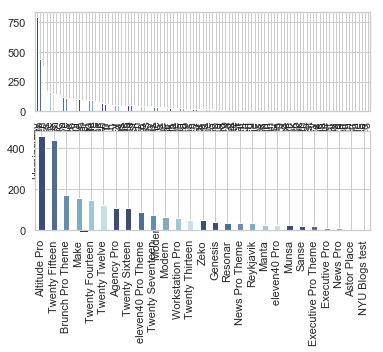

In [42]:
'''
TOOL/FEATURE USAGE
distribution of theme activations

We want to show that most usage is concentrated in a handful of themes.
'''

plt.subplot(211)
sites['current_theme'].loc[(sites['active'] == True) &\
                                    (sites['deleted'] == False)].value_counts().plot(kind='bar')


plt.subplot(212)
sites['current_theme'].loc[(sites['active'] == True) &\
                          (sites['accessible theme'] == True)].value_counts().plot(kind='bar')

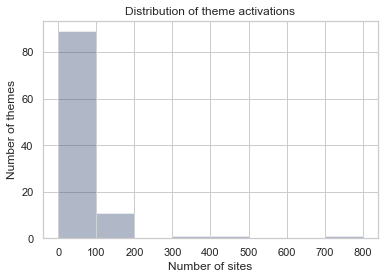

In [43]:
# another way of viewing the same data
ta_dist = sites['current_theme'].loc[(sites['active'] == True) &\
                                    (sites['deleted'] == False)].value_counts()
sns.distplot(ta_dist, kde=False, bins=[0,100,200,300,400,500,600,700,800])
plt.title("Distribution of theme activations")
plt.ylabel("Number of themes")
plt.xlabel("Number of sites")
plt.savefig("theme dist.png", format="png", dpi=600)

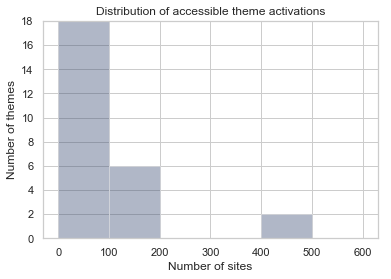

In [44]:
acc_theme = sites['current_theme'].loc[(sites['active'] == True) &\
                                       (sites['accessible theme'] == True)].value_counts()
g = sns.distplot(acc_theme, kde=False, bins=[0,100,200,300,400,500,600])
g.set(ylim=(0,18))
plt.title("Distribution of accessible theme activations")
plt.ylabel("Number of themes")
plt.xlabel("Number of sites")
plt.savefig("acc theme dist.png", format="png", dpi=600)

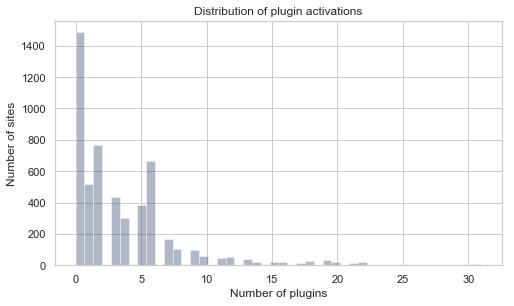

In [45]:
# distribution of plugin usage

p_dist = sites['total active'].loc[(sites['active'] == True)]
plt.figure(figsize=(8,4.5))
g = sns.distplot(p_dist, kde=False, hist=[2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32])
plt.title("Distribution of plugin activations")
plt.ylabel("Number of sites")
plt.xlabel("Number of plugins")
plt.savefig("plugin dist.png", format="png", dpi=600)

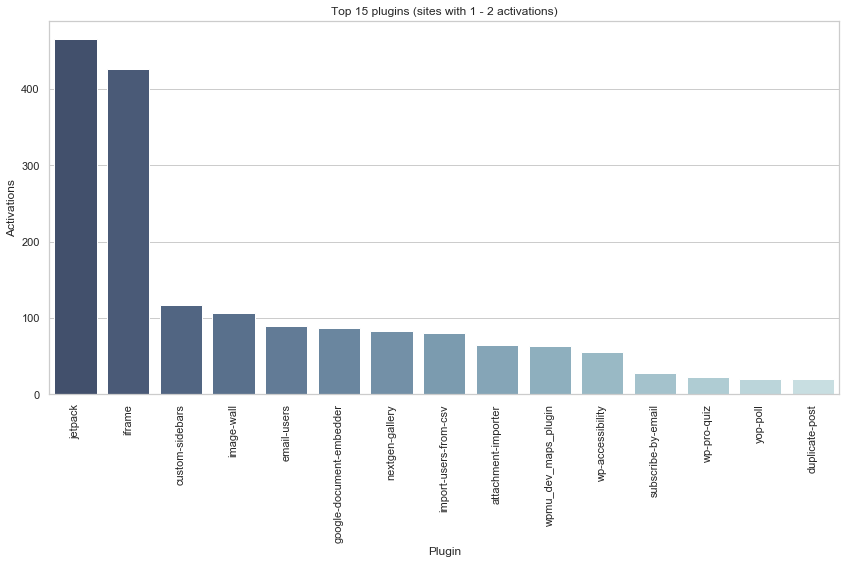

In [46]:
# find sites with 2 active plugins and graph

tp = sites[plugin_list].loc[(sites['active'] == True) & \
                  (sites['deleted'] == False) &\
                 (sites['total active'] <= 2)]
tp = tp.sum().sort_values(ascending=False).to_frame()[:15]
tp = tp.reset_index()
tp.columns = ['plugin','count']
plt.figure(figsize=(12,8))
g = sns.barplot(x='plugin',y='count',data=tp, palette="ch:r=-.2,d=.3_r")

# rotate x
for item in g.get_xticklabels():
   item.set_rotation(90)

# set labels
g.set(xlabel='Plugin', ylabel='Activations')
plt.title('Top 15 plugins (sites with 1 - 2 activations)')
plt.tight_layout()
plt.savefig("plugin activations.png", format="png", dpi=300)

count     5348.000000
mean        10.568437
std        153.892779
min          0.000000
25%          1.000000
50%          3.000000
75%          8.000000
max      11186.000000
Name: pages_count, dtype: float64

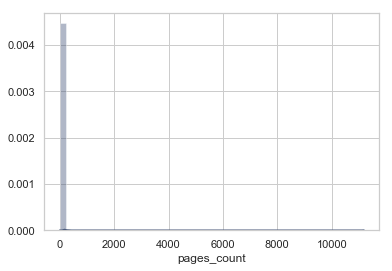

In [47]:
# page and post distribution
# pages
page_dist = sites['pages_count'].loc[(sites['active'] == True)]
sns.distplot(page_dist)

page_dist.describe()

count    5348.000000
mean       19.856956
std       183.727482
min         0.000000
25%         1.000000
50%         1.000000
75%         7.000000
max      7707.000000
Name: posts_count, dtype: float64

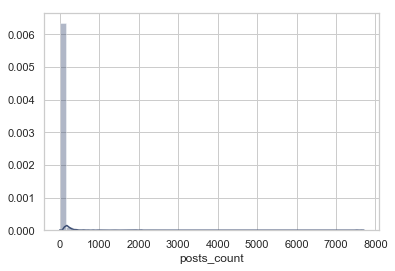

In [48]:
# posts

post_dist = sites['posts_count'].loc[(sites['active'] == True)]
sns.distplot(post_dist)

post_dist.describe()

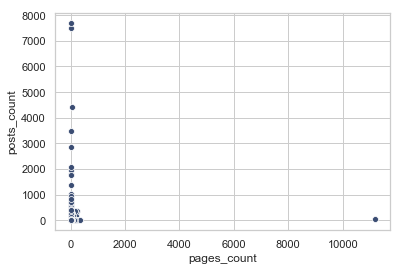

In [49]:
# pages vs posts
ax= sns.scatterplot(x='pages_count', y='posts_count', data=sites)

count                        9965
mean     180 days 03:30:55.792473
std      271 days 22:30:38.640457
min               0 days 04:00:00
25%               0 days 05:00:02
50%              35 days 04:58:16
75%             315 days 04:37:26
max            2078 days 19:46:04
Name: dur, dtype: object

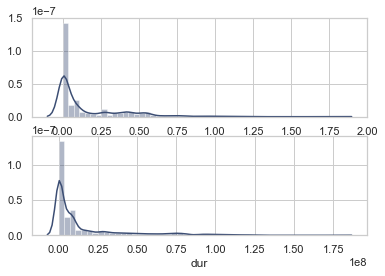

In [50]:
# site abandonment
# sites which are created, but never used

dur = sites['dur'].astype('timedelta64[s]')
dur.dropna(inplace=True)

plt.subplot(211)
sns.distplot(dur)

plt.subplot(212)
dura = sites['dur'].loc[sites['active'] ==True].astype('timedelta64[s]')
dura.dropna(inplace=True)
sns.distplot(dura)

sites['dur'].describe()


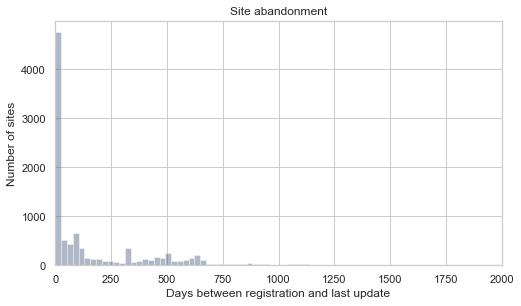

In [51]:
dur = sites['dur'].astype('timedelta64[D]')
dur.dropna(inplace=True)
plt.figure(figsize=(8,4.5))
sns.distplot(dur, kde=False, bins=80) #each bin = 25 days
plt.title("Site abandonment")
plt.ylabel("Number of sites")
plt.xlabel("Days between registration and last update")
plt.xlim((0,2000))
plt.savefig("abandonment dist.png", format="png", dpi=300)

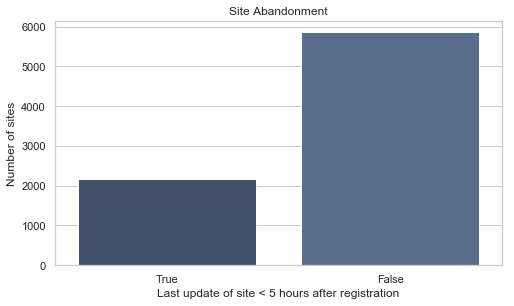

In [52]:
min_dur = pd.to_timedelta('0 days 05:00:00')
s = sites['dur'].loc[(sites['deleted'] == False) &\
                     (sites['archived'] == False)] < min_dur
plt.figure(figsize=(8,4.5))
sns.countplot(s, order=[True,False])
plt.title("Site Abandonment")
plt.ylabel("Number of sites")
plt.xlabel("Last update of site < 5 hours after registration")
plt.savefig("abandoned count.png", format="png", dpi=300)

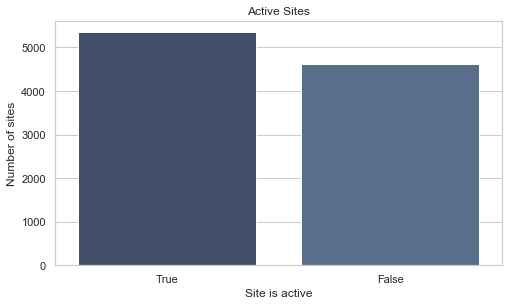

In [53]:
# sites are active or not
plt.figure(figsize=(8,4.5))
sns.countplot(x='active', data=sites, order=[True,False])
plt.title("Active Sites")
plt.ylabel("Number of sites")
plt.xlabel("Site is active")
plt.savefig("active sites.png", format="png", dpi=300)